In [1]:
import os
import gc
import optuna
import numpy as np
from utils import *
import pandas as pd
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, f1_score
%run skills.ipynb
%run languages.ipynb
%run work_experiences.ipynb
%run education.ipynb

class config:
    train_path = '../../../datasets/garanti-bbva-data-camp/train_users.csv'
    test_path = '../../../datasets/garanti-bbva-data-camp/test_users.csv'
    sub_path = '../../../datasets/garanti-bbva-data-camp/submission.csv'
    skills_path = '../../../datasets/garanti-bbva-data-camp/skills.csv'
    languages_path = '../../../datasets/garanti-bbva-data-camp/languages.csv'
    education_path = '../../../datasets/garanti-bbva-data-camp/education.csv'
    exp_path = '../../../datasets/garanti-bbva-data-camp/work_experiences.csv'
    seed = 42
    n_folds = 6

In [2]:
train_df = pd.read_csv(config.train_path)
test_df = pd.read_csv(config.test_path)
sub = pd.read_csv(config.sub_path)

print(f'train_df shape: {train_df.shape}')
print(f'test_df shape: {test_df.shape}')
df = train_df.append(test_df).reset_index(drop = True)
df.head()

train_df shape: (53019, 4)
test_df shape: (13255, 3)


,user_id,industry,location,moved_after_2019
0,1301,Information Technology and Services,"Istanbul, Istanbul, Turkey",1.0
1,6950,Internet,"Istanbul, Istanbul, Turkey",0.0
2,4880,Online Media,Turkey,0.0
3,26046,Telecommunications,"Istanbul, Istanbul, Turkey",0.0
4,11005,Banking,"Istanbul, Turkey",0.0


In [40]:
#df.loc[df['location'].astype(str).str.contains('Afyon')]

In [3]:
def fix_location(dataframe: pd.DataFrame) -> pd.DataFrame:

    df_ = dataframe.copy()
    df_.loc[df_['location'].astype(str).str.contains('Kahraman Maras'), 'location'] = 'Kahramanmaras, Turkey'
    df_.loc[df_['location'].astype(str).str.contains('Şanliurfa'), 'location'] = 'Sanliurfa, Turkey'
    df_.loc[df_['location'].astype(str).str.contains('İçel'), 'location'] = 'Mersin, Turkey'
    df_.loc[df_['location'].astype(str).str.contains('Afyon'), 'location'] = 'Afyonkarahisar, Turkey'
    df_['location'] = df_['location'].apply(lambda x: str(x).replace('Türkiye', 'Turkey'))
    df_['location'] = df_['location'].apply(lambda x: x.upper().strip())
    df_['location'] = df_['location'].apply(lambda x: translation(str(x)))
    tr_cities = load_tr_cities()
    for city in tr_cities:
        df_['location'] = df_['location'].apply(lambda x: city if city in x else x)
        df_['based_on_tr'] = df_['location'].apply(lambda x: 1 if x in tr_cities or x == 'TURKEY' else 0)

    return df_

df = fix_location(df)

In [4]:
skills_df = load_skills(config.skills_path, 30)
lang_df = load_languages(config.languages_path)
edu_df = load_education(config.education_path, 12)
exp_df = load_work_experiences(config.exp_path)

df = df.merge(skills_df, on = ['user_id'], how = 'left')
df = df.merge(lang_df, on = ['user_id'], how = 'left')
df = df.merge(edu_df, on = ['user_id'], how = 'left')
df = df.merge(exp_df, on = ['user_id'], how = 'left')

print(df.shape)
df.head()

Frequency of top 20 skills before preprocess: 294433
Frequency of top 20 skills after preprocess: 320842


100%|██████████| 10/10 [00:02<00:00,  4.17it/s]


(66274, 80)


,user_id,industry,location,moved_after_2019,based_on_tr,skill_Java,skill_JavaScript,skill_C#,skill_SQL,skill_Software Development,...,degree_Bachelor of Engineering,degree_Doctor of Philosophy,degree_Master of Business Administration,degree_Mühendislik Fakültesi Mezunu,total_experience,last_experience,nunique_company,employee_avg_days_to_quit,company_id,company_avg_days_to_quit
0,1301,Information Technology and Services,ISTANBUL,1.0,1,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1341.0,306.0,3.0,447.000000,26.0,912.280537
1,6950,Internet,ISTANBUL,0.0,1,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,2101.0,699.0,4.0,525.250000,1337.0,393.769231
2,4880,Online Media,TURKEY,0.0,1,0.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1826.0,610.0,4.0,456.500000,4366.0,NaN
3,26046,Telecommunications,ISTANBUL,0.0,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3409.0,1553.0,1.0,3409.000000,26.0,912.280537
4,11005,Banking,ISTANBUL,0.0,1,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3409.0,640.0,3.0,1136.333333,1562.0,837.166667


In [7]:
df['nunique_company_by_industries'] = df.groupby(by = 'industry')['company_id'].transform('nunique')

In [8]:
target = 'moved_after_2019'
cat_features = ['industry', 'location', 'company_id']
drop_features = ['user_id']

for caterogical_col in cat_features:
    df[caterogical_col] = df[caterogical_col].astype(str).astype("category")

train_set = df.loc[df[target].notnull()].drop(columns=drop_features, axis = 1)
test_set = df.loc[df[target].isnull()].drop(columns=drop_features, axis = 1)

print(f'train_set: {train_set.shape}')
print(f'test_set: {test_set.shape}')

train_set: (53019, 80)
test_set: (13255, 80)


In [9]:
# CatBoost Parameters
params = {'one_hot_max_size': 179, 'depth': 12, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}

params['verbose'] = False
params['random_state'] = config.seed
params['cat_features'] = cat_features
params['eval_metric'] = 'Accuracy'
params['allow_writing_files'] = False
params["iterations"] = 5000

## XGB Parameters
#params = {'max_depth': 10,
#          'subsample': 0.8,
#          'eta': 0.02,
#          'reg_alpha': 2,
#          'reg_lambda': 24,
#          'learning_rate': 0.01}
#
##params['eval_metric'] = 'Accuracy'
#params['random_state'] = config.seed
#params['tree_method'] = 'hist'
#params['n_estimators'] = 5000
#params['enable_categorical'] = True

kf = KFold(n_splits=config.n_folds)


In [10]:
X = train_set.drop(columns=[target], axis=1)
y = train_set[target]
features = X.columns

X_test = test_set.drop(columns=[target], axis=1)
y_oof = np.zeros(X.shape[0])
y_pred = np.zeros(X_test.shape[0])

-----------------------------------| Fold 1 |-----------------------------------
Learning rate set to 0.040108
0:	learn: 0.6503327	test: 0.6386783	best: 0.6386783 (0)	total: 276ms	remaining: 22m 57s
200:	learn: 0.8605993	test: 0.7481046	best: 0.7485572 (195)	total: 30.1s	remaining: 11m 59s
400:	learn: 0.9105971	test: 0.7603259	best: 0.7607785 (398)	total: 59.1s	remaining: 11m 18s
600:	learn: 0.9371463	test: 0.7657576	best: 0.7659839 (597)	total: 1m 29s	remaining: 10m 53s
800:	learn: 0.9536915	test: 0.7691524	best: 0.7699446 (764)	total: 1m 59s	remaining: 10m 26s
1000:	learn: 0.9659816	test: 0.7725472	best: 0.7729999 (997)	total: 2m 28s	remaining: 9m 52s
1200:	learn: 0.9738355	test: 0.7728867	best: 0.7739052 (1127)	total: 2m 57s	remaining: 9m 20s
1400:	learn: 0.9801050	test: 0.7731130	best: 0.7739052 (1127)	total: 3m 27s	remaining: 8m 52s
Stopped by overfitting detector  (400 iterations wait)

bestTest = 0.7739051714
bestIteration = 1127

Shrink model to first 1128 iterations.


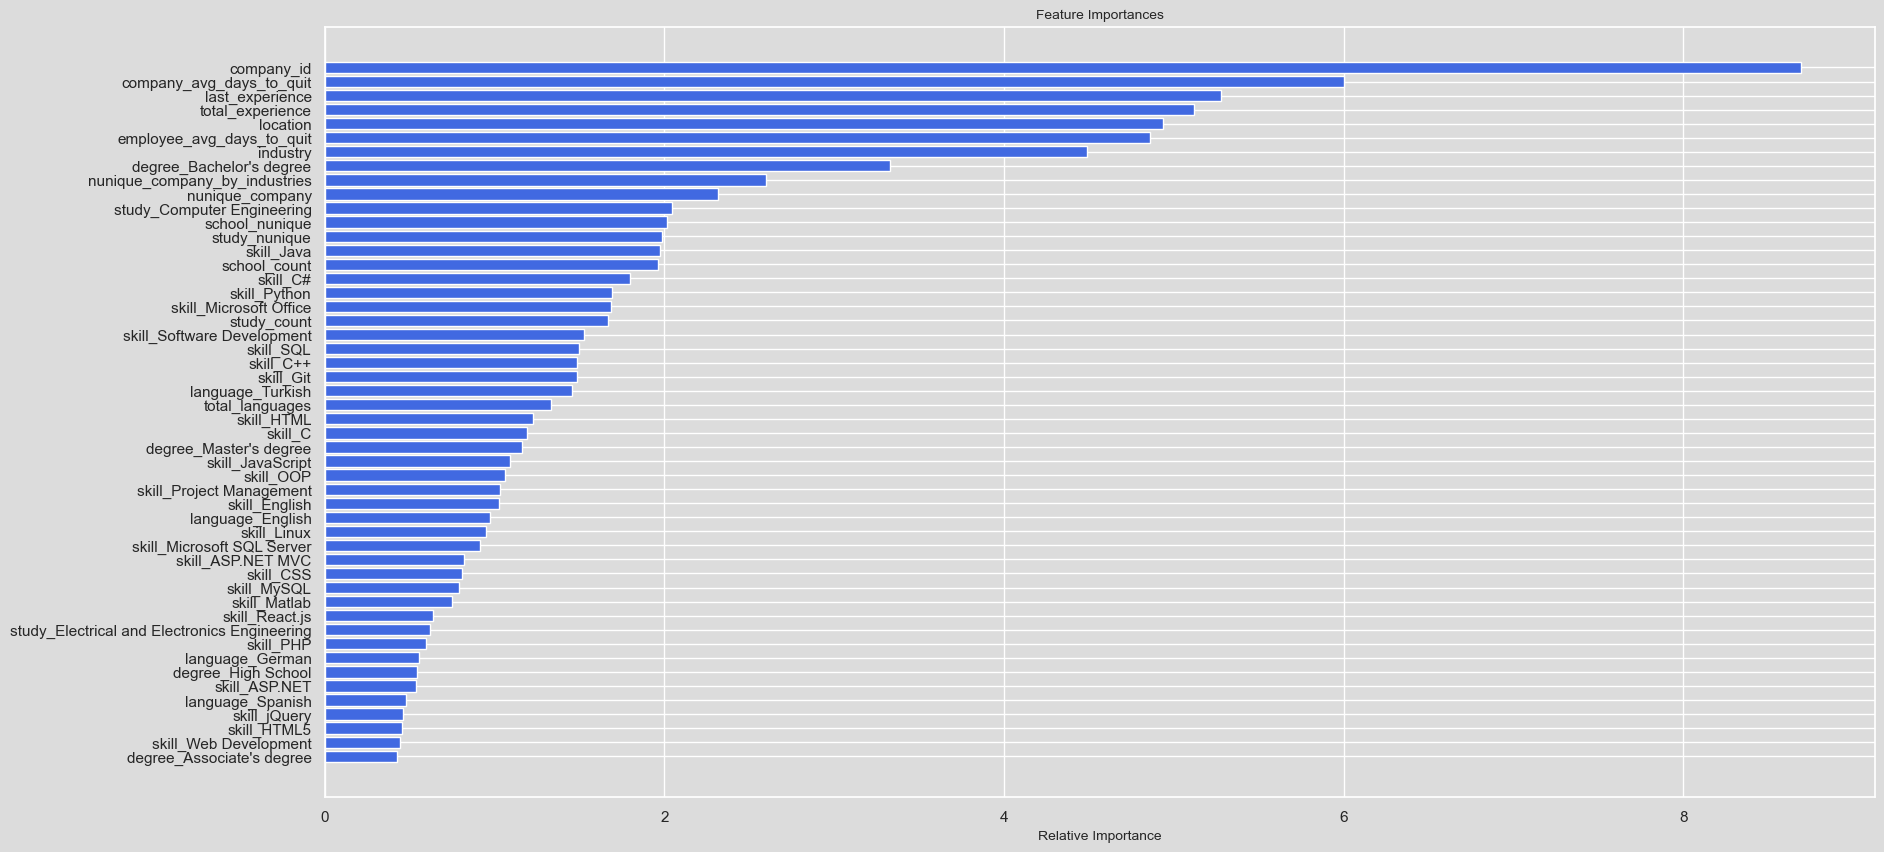

fold accuracy: 0.7739051714382709
-----------------------------------| Fold 2 |-----------------------------------
Learning rate set to 0.040108
0:	learn: 0.6642977	test: 0.6407152	best: 0.6407152 (0)	total: 193ms	remaining: 16m 2s
200:	learn: 0.8574985	test: 0.7554600	best: 0.7556863 (192)	total: 30.1s	remaining: 11m 57s
400:	learn: 0.9109818	test: 0.7694919	best: 0.7700577 (391)	total: 59.7s	remaining: 11m 24s
600:	learn: 0.9381649	test: 0.7753763	best: 0.7753763 (599)	total: 1m 28s	remaining: 10m 50s
800:	learn: 0.9547780	test: 0.7799027	best: 0.7804685 (788)	total: 1m 57s	remaining: 10m 17s
1000:	learn: 0.9661627	test: 0.7820527	best: 0.7831843 (985)	total: 2m 27s	remaining: 9m 50s
1200:	learn: 0.9746956	test: 0.7837501	best: 0.7853344 (1173)	total: 2m 57s	remaining: 9m 20s
1400:	learn: 0.9797655	test: 0.7832975	best: 0.7856739 (1307)	total: 3m 26s	remaining: 8m 50s
1600:	learn: 0.9840885	test: 0.7832975	best: 0.7856739 (1307)	total: 3m 57s	remaining: 8m 23s
Stopped by overfitting 

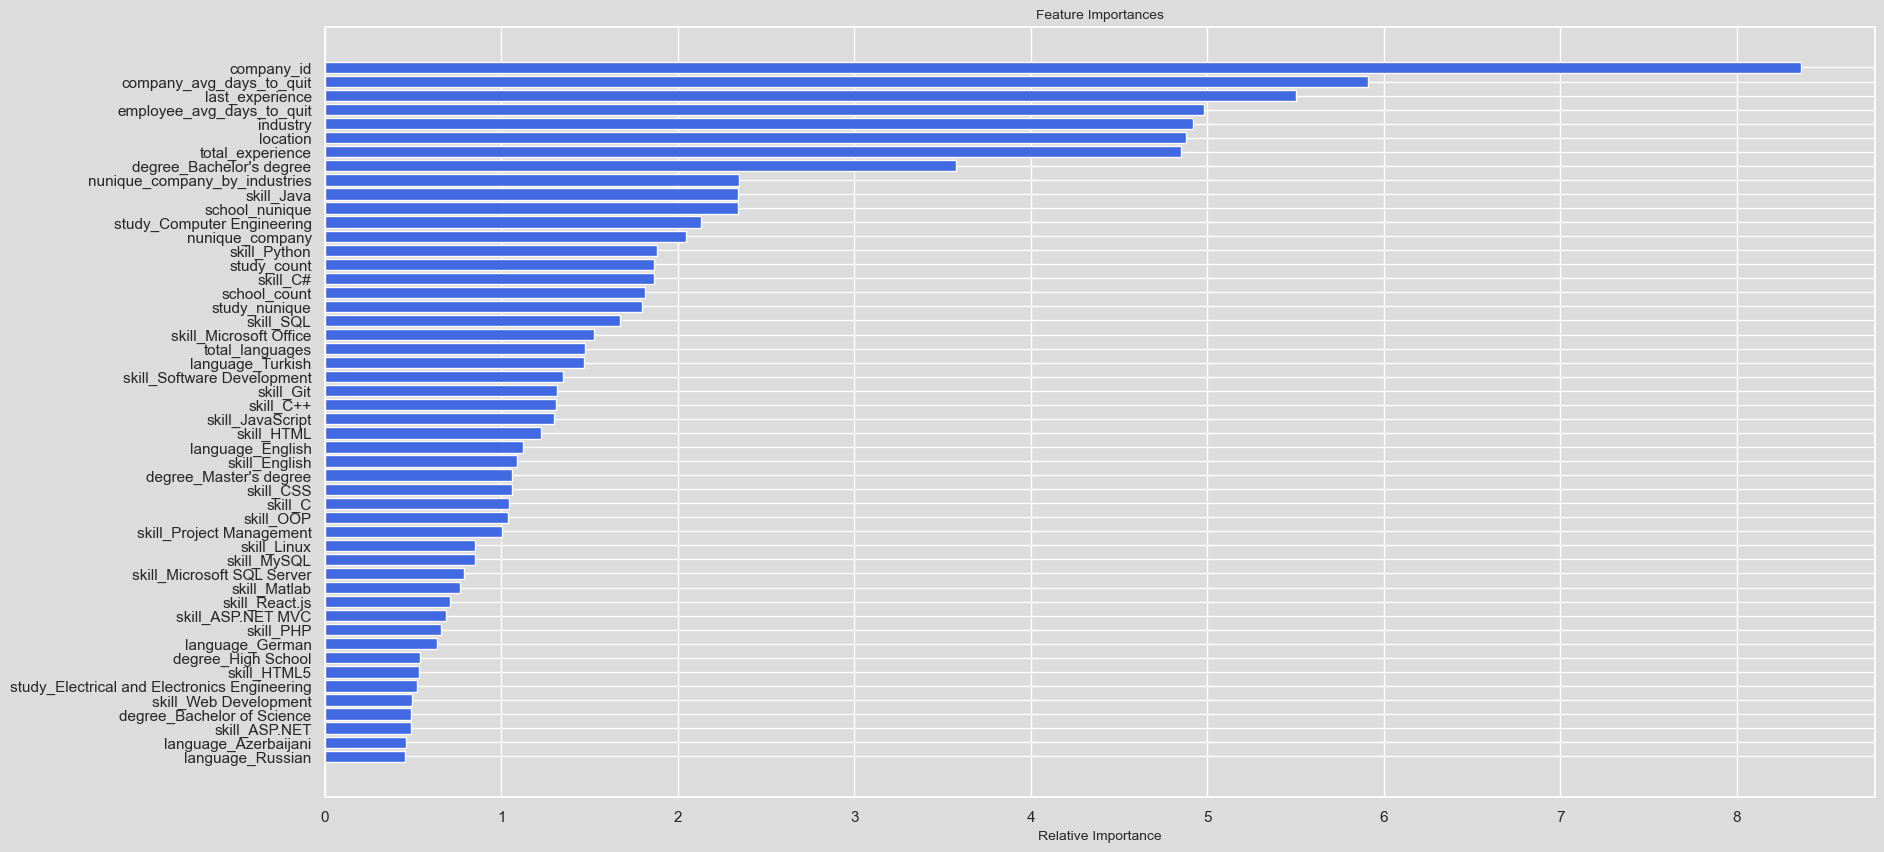

fold accuracy: 0.7856738712232658
-----------------------------------| Fold 3 |-----------------------------------
Learning rate set to 0.040108
0:	learn: 0.6601105	test: 0.6369809	best: 0.6369809 (0)	total: 187ms	remaining: 15m 35s
200:	learn: 0.8578607	test: 0.7526310	best: 0.7526310 (199)	total: 29.9s	remaining: 11m 54s
400:	learn: 0.9116156	test: 0.7666629	best: 0.7666629 (389)	total: 59.2s	remaining: 11m 19s
600:	learn: 0.9377801	test: 0.7672287	best: 0.7682471 (474)	total: 1m 28s	remaining: 10m 49s
800:	learn: 0.9536236	test: 0.7708498	best: 0.7710762 (788)	total: 1m 57s	remaining: 10m 16s
1000:	learn: 0.9651215	test: 0.7725472	best: 0.7735657 (981)	total: 2m 26s	remaining: 9m 46s
1200:	learn: 0.9733602	test: 0.7720946	best: 0.7735657 (981)	total: 2m 55s	remaining: 9m 15s
1400:	learn: 0.9787017	test: 0.7728867	best: 0.7743578 (1324)	total: 3m 24s	remaining: 8m 45s
1600:	learn: 0.9832737	test: 0.7740183	best: 0.7751499 (1571)	total: 3m 53s	remaining: 8m 16s
1800:	learn: 0.9863972	

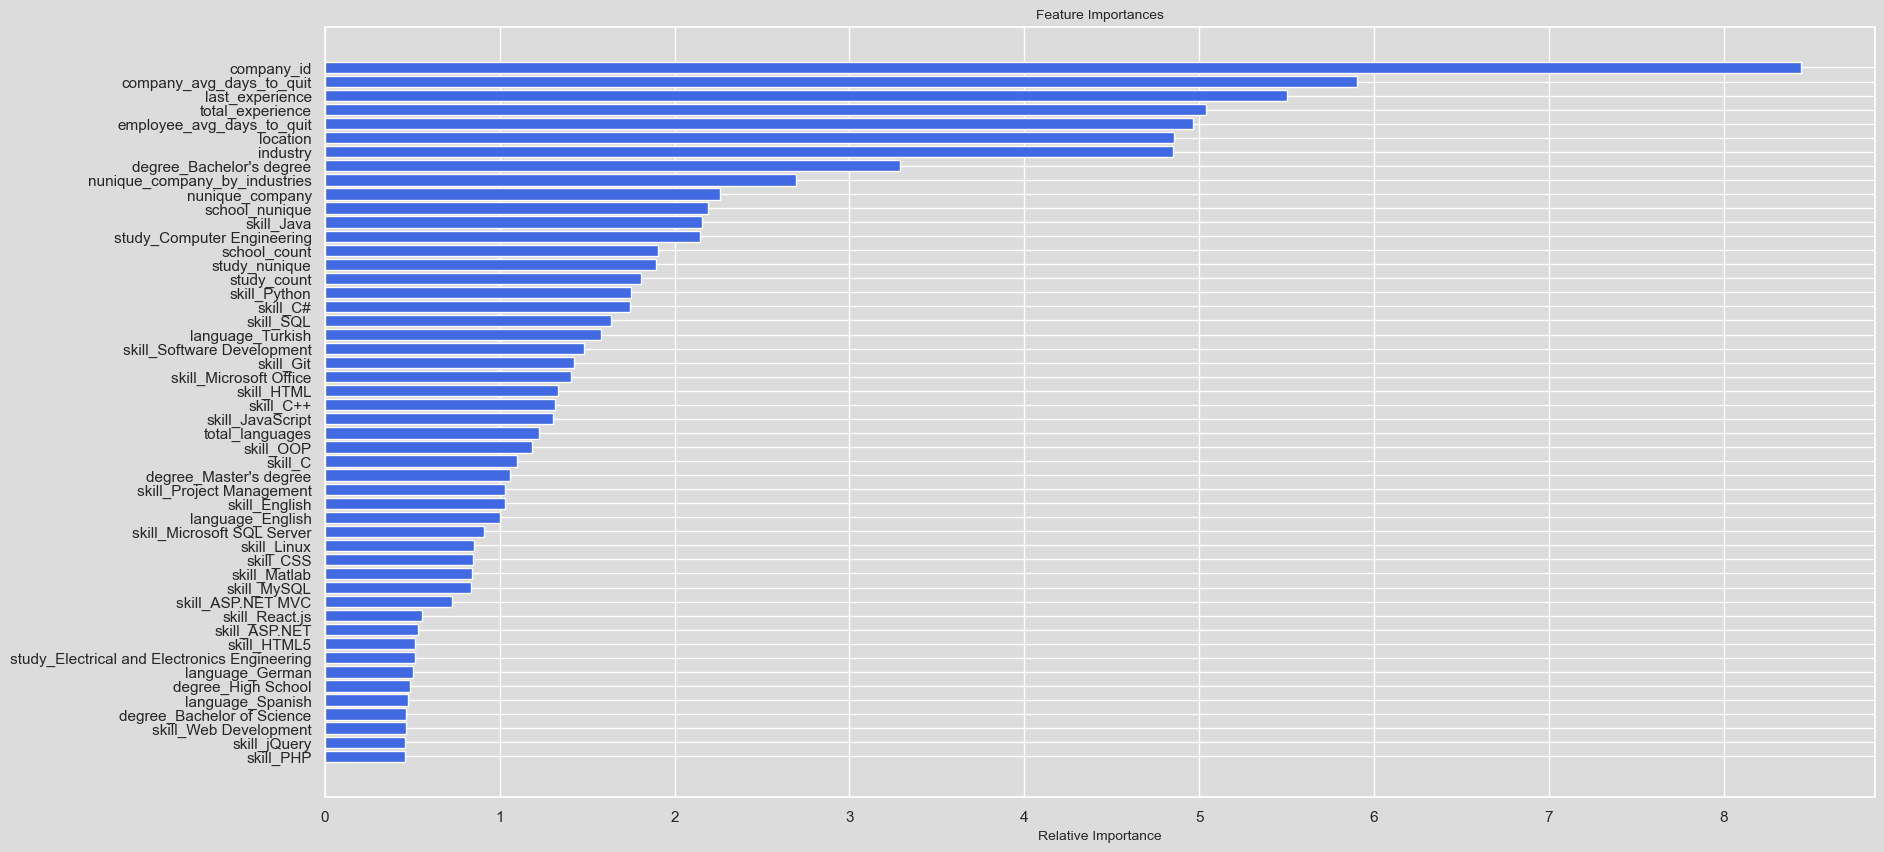

fold accuracy: 0.7751499377616838
-----------------------------------| Fold 4 |-----------------------------------
Learning rate set to 0.040108
0:	learn: 0.6481678	test: 0.6277727	best: 0.6277727 (0)	total: 193ms	remaining: 16m 4s
200:	learn: 0.8600819	test: 0.7483024	best: 0.7484156 (199)	total: 28.9s	remaining: 11m 29s
400:	learn: 0.9135867	test: 0.7638072	best: 0.7641467 (377)	total: 57.9s	remaining: 11m 4s
600:	learn: 0.9387774	test: 0.7670892	best: 0.7678814 (588)	total: 1m 26s	remaining: 10m 36s
800:	learn: 0.9547337	test: 0.7701449	best: 0.7720688 (788)	total: 1m 56s	remaining: 10m 8s
1000:	learn: 0.9659371	test: 0.7743323	best: 0.7750113 (964)	total: 2m 25s	remaining: 9m 39s
1200:	learn: 0.9743567	test: 0.7744455	best: 0.7755772 (1123)	total: 2m 54s	remaining: 9m 11s
1400:	learn: 0.9804902	test: 0.7754640	best: 0.7773880 (1373)	total: 3m 23s	remaining: 8m 42s
1600:	learn: 0.9846095	test: 0.7744455	best: 0.7773880 (1373)	total: 3m 52s	remaining: 8m 13s
Stopped by overfitting de

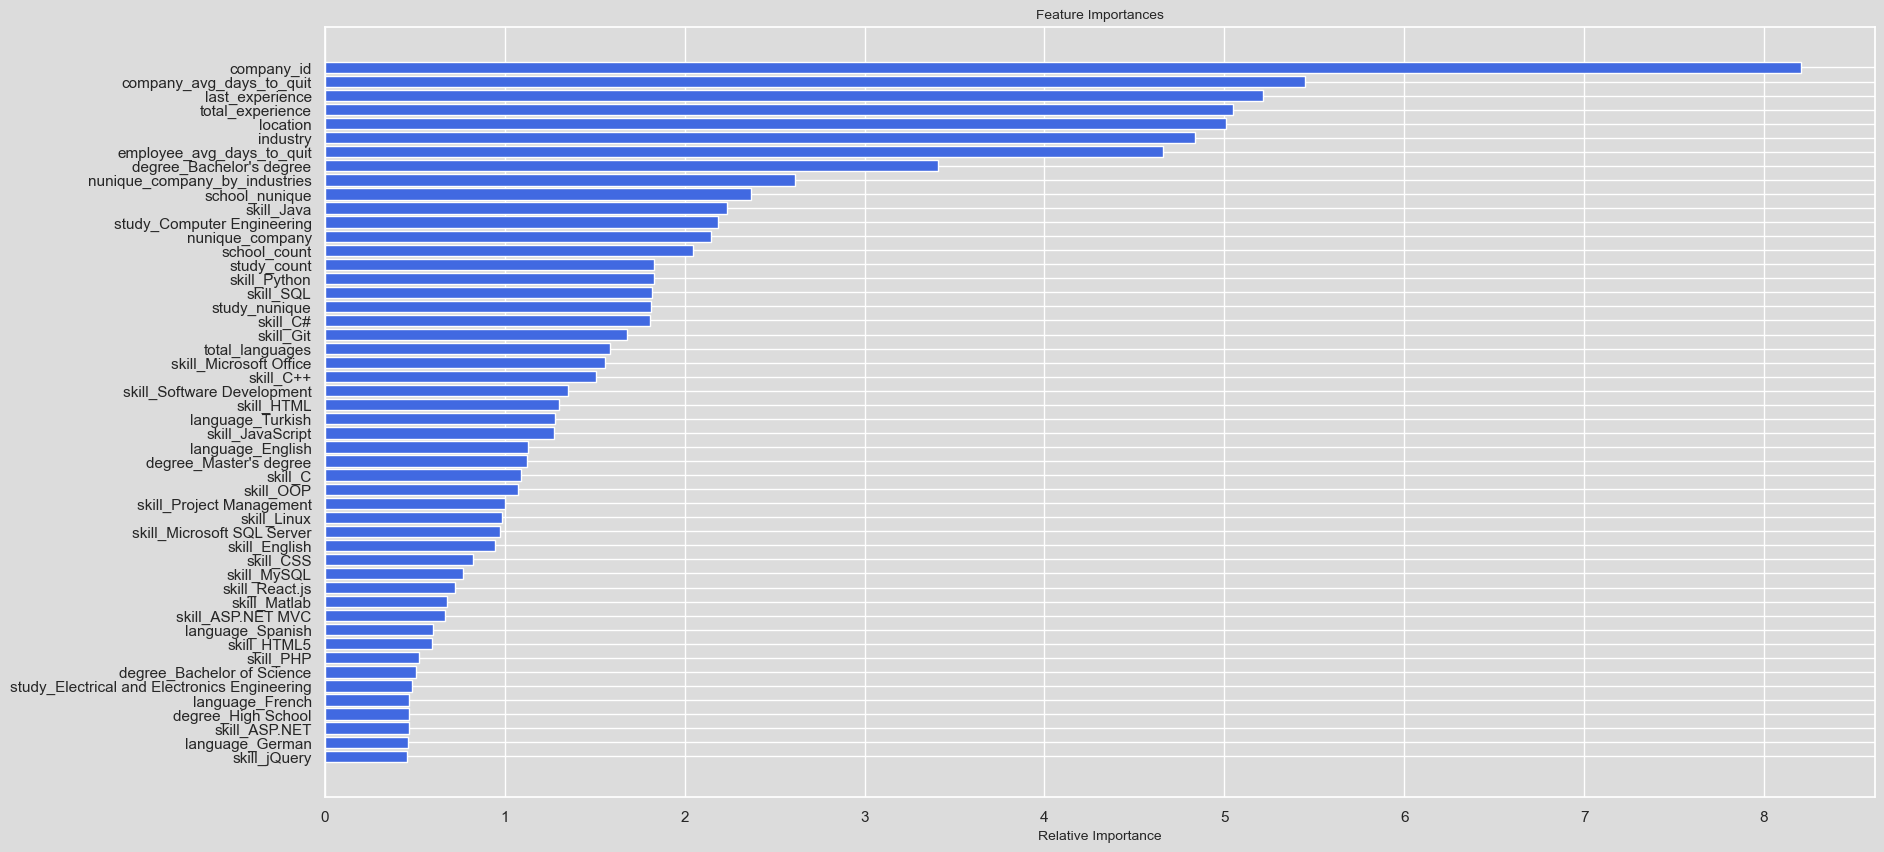

fold accuracy: 0.7773879583521955
-----------------------------------| Fold 5 |-----------------------------------
Learning rate set to 0.040108
0:	learn: 0.6542335	test: 0.6377320	best: 0.6377320 (0)	total: 208ms	remaining: 17m 20s
200:	learn: 0.8544463	test: 0.7547533	best: 0.7563377 (197)	total: 33.4s	remaining: 13m 17s
400:	learn: 0.9131793	test: 0.7667497	best: 0.7672024 (383)	total: 1m 7s	remaining: 12m 51s
600:	learn: 0.9404069	test: 0.7742191	best: 0.7750113 (586)	total: 1m 41s	remaining: 12m 20s
800:	learn: 0.9584003	test: 0.7795383	best: 0.7795383 (800)	total: 2m 15s	remaining: 11m 48s
1000:	learn: 0.9684041	test: 0.7801041	best: 0.7807832 (813)	total: 2m 48s	remaining: 11m 14s
1200:	learn: 0.9757373	test: 0.7828203	best: 0.7829335 (1196)	total: 3m 22s	remaining: 10m 41s
1400:	learn: 0.9818256	test: 0.7775011	best: 0.7829335 (1196)	total: 3m 56s	remaining: 10m 8s
Stopped by overfitting detector  (400 iterations wait)

bestTest = 0.7829334541
bestIteration = 1196

Shrink model

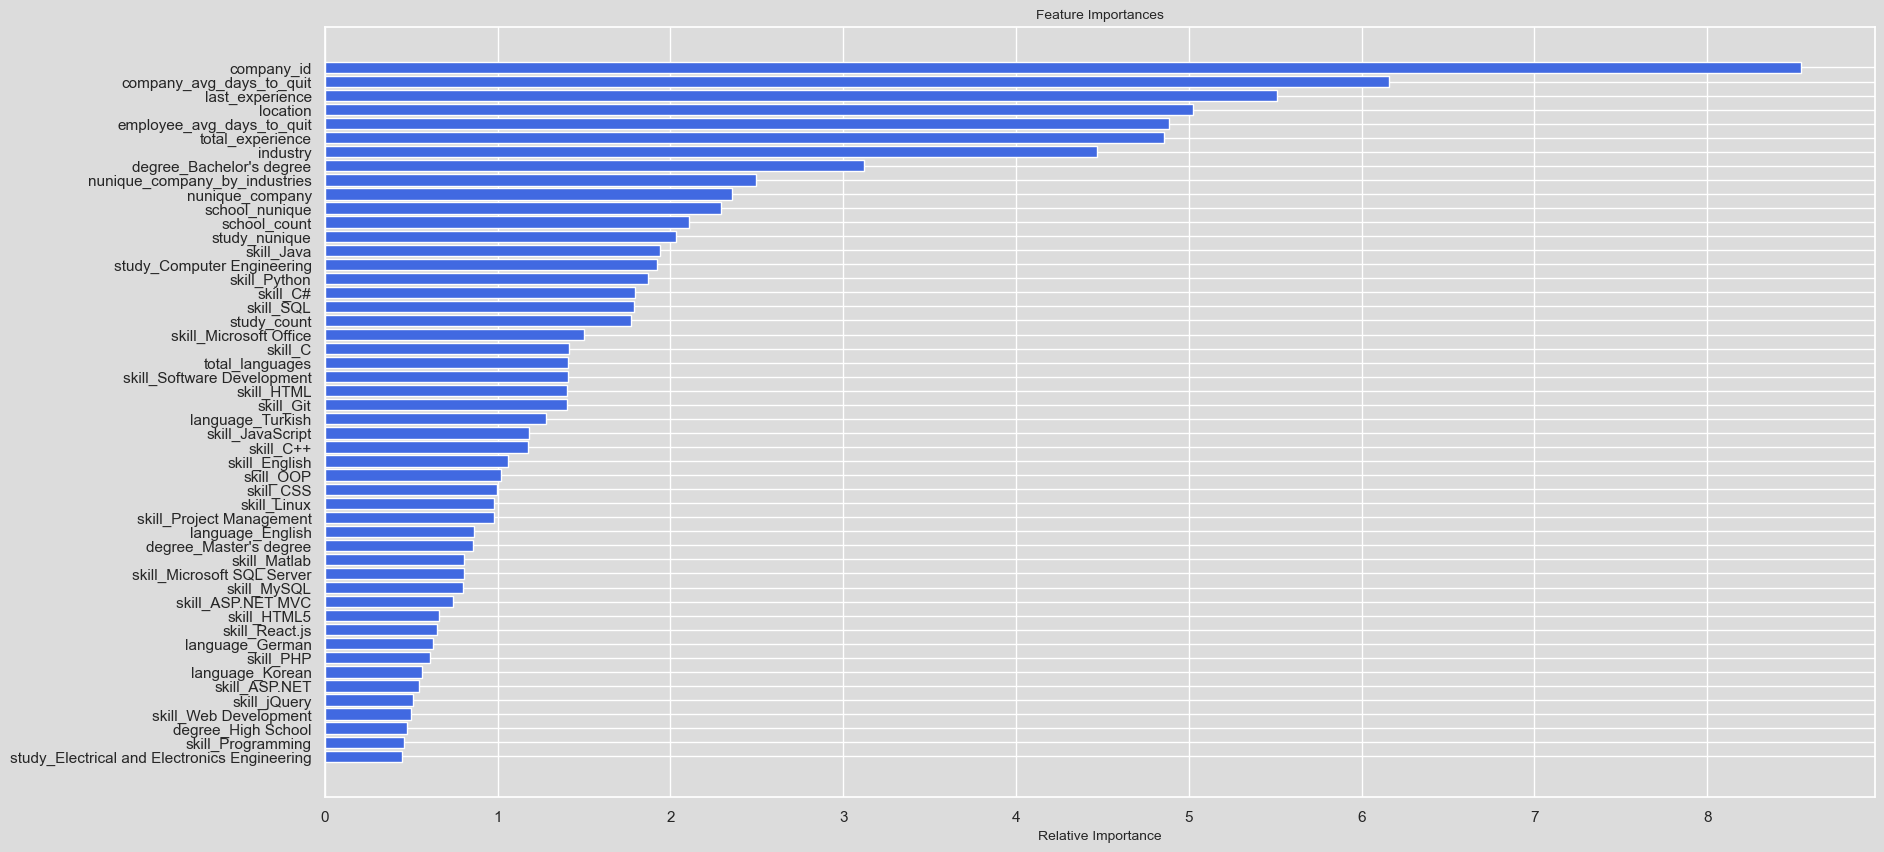

fold accuracy: 0.7829334540516071
-----------------------------------| Fold 6 |-----------------------------------
Learning rate set to 0.040108
0:	learn: 0.6573795	test: 0.6327524	best: 0.6327524 (0)	total: 196ms	remaining: 16m 17s
200:	learn: 0.8553516	test: 0.7404934	best: 0.7406066 (196)	total: 29.1s	remaining: 11m 34s
400:	learn: 0.9052803	test: 0.7564509	best: 0.7574694 (377)	total: 58.2s	remaining: 11m 7s
600:	learn: 0.9341602	test: 0.7631281	best: 0.7635808 (593)	total: 1m 27s	remaining: 10m 40s
800:	learn: 0.9510445	test: 0.7668628	best: 0.7681077 (773)	total: 1m 56s	remaining: 10m 12s
1000:	learn: 0.9636964	test: 0.7675419	best: 0.7686736 (957)	total: 2m 25s	remaining: 9m 43s
1200:	learn: 0.9725686	test: 0.7724083	best: 0.7724083 (1194)	total: 2m 56s	remaining: 9m 17s
1400:	learn: 0.9778422	test: 0.7712766	best: 0.7729742 (1243)	total: 3m 25s	remaining: 8m 47s
1600:	learn: 0.9819161	test: 0.7721820	best: 0.7729742 (1243)	total: 3m 54s	remaining: 8m 17s
1800:	learn: 0.9853564	

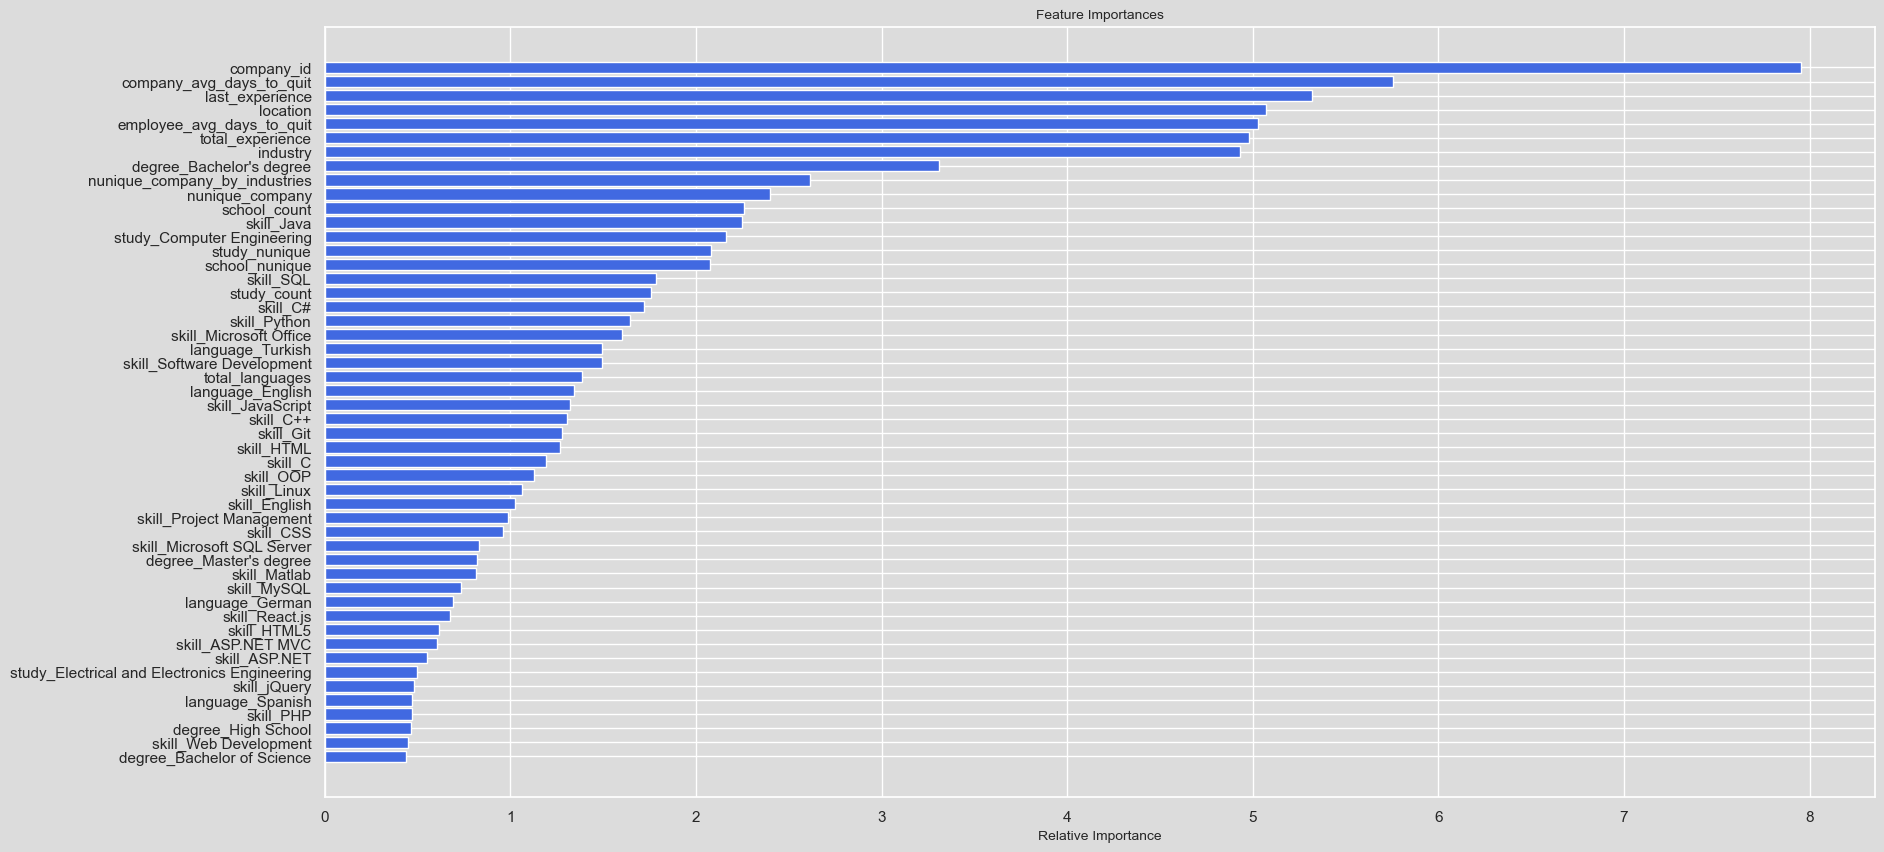

fold accuracy: 0.7778406518786781
accuracy: 0.7788151417416398


In [11]:
for idx, (train_ind, val_ind) in enumerate(kf.split(X, y)):
    print(f"| Fold {idx+1} |".center(80, "-"))
    model = CatBoostClassifier(**params)
    #model = XGBClassifier(**params)
    X_train = X.iloc[train_ind]
    y_train = y.iloc[train_ind]
    X_val = X.iloc[val_ind]
    y_val = y.iloc[val_ind]

    model.fit(
        X_train,
        y_train,
        eval_set=[(X_val, y_val)],
        early_stopping_rounds=400,
        verbose=200,
    )

    plot_importances(model, features)

    val_pred = model.predict(X_val)
    y_oof[val_ind] += val_pred

    test_pred = model.predict(X_test)
    y_pred += test_pred / config.n_folds

    print(f'fold accuracy: {accuracy_score(y_val, val_pred)}')
    del X_train, y_train, X_val, y_val
    gc.collect()

val_score = accuracy_score(y, y_oof)
print(f'accuracy: {val_score}')

accuracy: 0.7706293970086195

In [12]:
sub[target] = np.where(y_pred >= 0.5, 1, 0).tolist()

sub.head()

,user_id,moved_after_2019
0,17449,0
1,33967,1
2,2110,0
3,55082,0
4,37165,0


In [48]:
sub.to_csv(f'../submissions/submission_{round(val_score, 6)}.csv', index = False)